# Vision artificielle - TP Traitement d'images

L'objectif de ce TP est de se familiariser avec quelques techniques classiques de traitement d'images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imsave, imshow
from skimage.filters import threshold_otsu

# Images de test

Quelques images de test sont fournies avec ce notebook.
Vous pouvez les utiliser tout au long de la séance pour afficher et vérifier vos résultats.

Voici la liste :

In [2]:
%ls

barbara.png      lena-rgb.png        scotland_plain.jpg
cameraman.png    mandril_color.png   test-histo1.png
fingerprint.png  page.png            test-histo2.png
house.png        peppers.png         tp-traitement-images.ipynb
lake.png         README.md
lena.png         scotland_house.jpg


Quelques exemples :

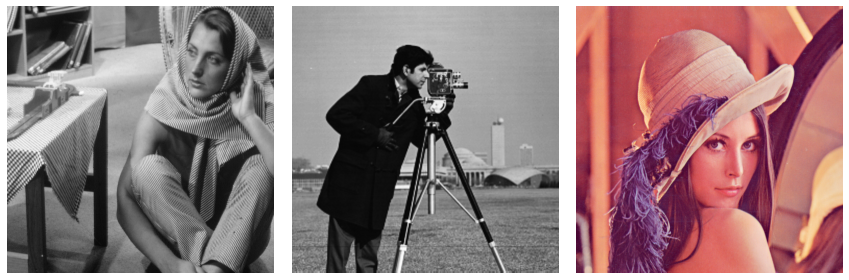

In [31]:
# Ensure grayscale images are diplayed in grey levels
plt.rcParams["image.cmap"] = 'gray'

list_images = ['barbara.png', 'cameraman.png', 'lena-rgb.png']
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(131+i)
    im = imread(list_images[i])
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

Lorsque vous effectuez des transformations sur les images, faites attention aux types que vous manipulez.
Par exemple, si une image est en `uint8` (pixels codés sur un 1 octet), les valeurs sont limitées à l'intervalle $[0, 255]$.
N'hésitez pas à convertir si nécessaire, par exemple avec la fonction `astype` (ou à vérifier le type après une opération).

In [4]:
im = imread('barbara.png')
print(im.dtype)
topleft = im[0, 0]
im[0, 0] = -1 # Impossible en uint8
print(im[0, 0])

im = im.astype(int)
print(im.dtype)
im[0, 0] = -1 # OK
print(im[0, 0])

im[0, 0] = topleft
im = np.log(1 + im) # Conversion en float
print(im.dtype)

uint8
255
int64
-1
float64


Au besoin, il faut également spécifier les valeurs minimales et maximales de la fonction d'affichage `imshow` :

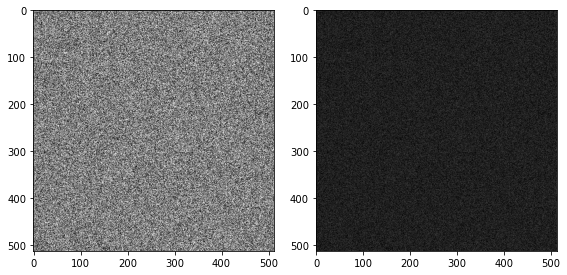

In [32]:
im = np.random.randint(0, 64, size=(512, 512), dtype=np.uint8) # Pixels aléatoires entre 0 et 64
plt.figure(figsize=(8, 4))
plt.subplot(121); plt.imshow(im) # De base, imshow remet à l'échelle les valeurs
plt.subplot(122); plt.imshow(im, vmin=0, vmax=255) # Spécifier vmin et vmax
plt.tight_layout()

# Manipulation d'histogramme

L’histogramme d'une image à niveaux de gris est défini comme l'ensemble des fréquences d’apparition des différentes valeurs des pixels.
Pour chaque niveau de gris possible (entre 0 et 255 pour une image codée sur 8 bits), on associe le nombre de pixels dans l'image qui ont cette valeur.

Généralement, on normalise les valeurs de l'histogramme par le nombre total de pixels de l'image : l'histogramme peut alors être assimilé à une distribution de probabilités.

L'histogramme nous informe sur la répartition des niveaux de gris (contraste), ainsi que sur les niveaux de gris les plus représentés (modes).
Il est cependant dépourvu de toute information spatiale.

1. Calculer et afficher l'histogramme d'une image. Tester le résultat pour le plusieurs images. Penser également à normaliser l'histogramme par le nombre de pixels dans l'image.

In [6]:
def plotHist(image, d = False, c = False):
    
    values = []
    edges = []
    
    # Single channel images
    if len(image.shape) == 2:
        
        b = len(list(set(image.flatten())))
        n, bins, _ = plt.hist(image.flatten(), bins = b, density = d, cumulative = c, color = 'b')
        values.append(n)
        edges.append(bins)

    # Multiple channels images
    else:
        for i in range(image.shape[2]):
            
            b = len(list(set(image[:,:,i].flatten())))
            
            n, bins, _ = plt.hist(image[:,:,i].flatten(), bins = b, density = d, cumulative = c, color = 'b')
            values.append(n)
            edges.append(bins)
            plt.title("Histogram for channel " + str(i))
            plt.show()
            
    return values, edges

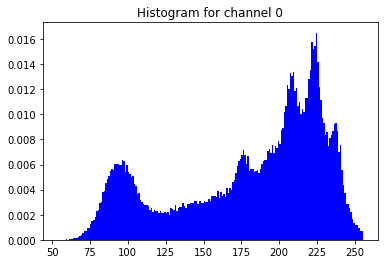

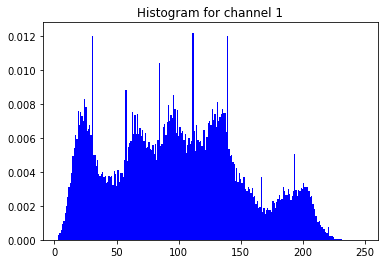

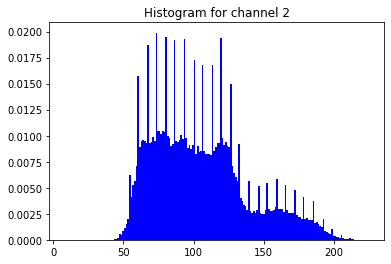

In [7]:
im = imread('lena-rgb.png')
values, edges = plotHist(im, d = True)

2. Appliquer un étirement d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : l'étirement d'histogramme consiste simplement à répartir les fréquences d'apparition des pixels sur toute la largeur de l'histogramme.

In [8]:
def stretch(image):
    
    max_val = np.max(image)
    min_val = np.min(image)
    
    #print(max_val)
    #print(min_val)
    
    s = lambda x: 255 * ((x - min_val) / (max_val - min_val))
    
    toret = np.copy(image)
    
    return s(toret)

In [19]:
def imagesPlot(image1, image2, title1, title2):

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image1, vmin=0, vmax=255)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(image2, vmin=0, vmax=255)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()

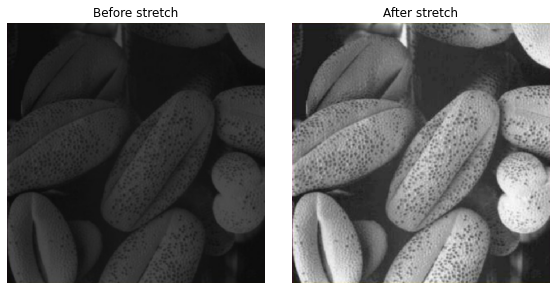

In [25]:
test1 = imread('test-histo1.png')
test2 = imread('test-histo2.png')

t1 = stretch(test1).astype('uint8')

imagesPlot(test1, t1, "Before stretch", "After stretch")

3. Appliquer une égalisation d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : les pixels de valeur $k$ auront pour nouvelle valeur $255 \times C(k)$ où $C(k) = \sum_0^k H(k)$

In [11]:
def getClass(p, bins):
    
    return np.argmax(bins>p) - 1 

def equalize(image, values, bins):
    
    new_image = np.copy(image)
    
    if len(image.shape) == 2:
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                new_image[i,j] = 255 * values[0][getClass(image[i,j], bins[0])]
        
    else:   
        for c in range(image.shape[2]):
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    new_image[i,j,c] = 255 * values[c][getClass(image[i,j,c], bins[c])]
        
    
    return new_image

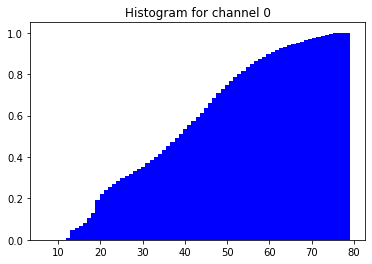

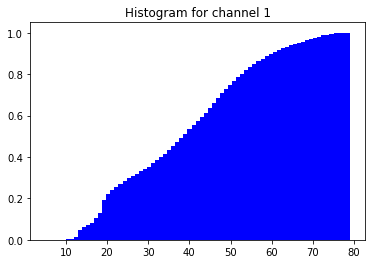

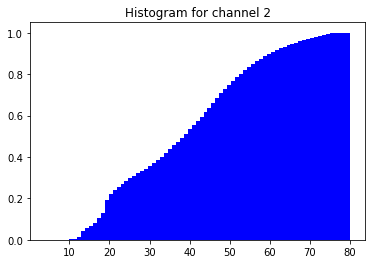

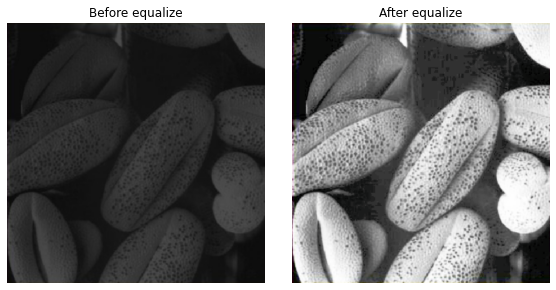

In [12]:
# Compute Cumulative histograms
# values contains C(k), and bins the borders of each class k
values, bins = plotHist(test1, d = True, c = True)

imagesPlot(test1, equalize(test1, values, bins), "Before equalize", "After equalize")

4. Appliquer des opérations de binarisation par seuillage à différents niveaux. Utiliser par exemple les images `fingerprint.png` et `page.png`. Tester la méthode d'Otsu dans la librairie `skimage` pour déterminer automatiquement un seuil.

In [27]:
def threshold(image, T):
    
    t = lambda x: 255 if x <= T else 0
    
    res = [t(x) for x in image.flatten()]
    
    res = np.reshape(np.asarray(res), image.shape)

    return res 

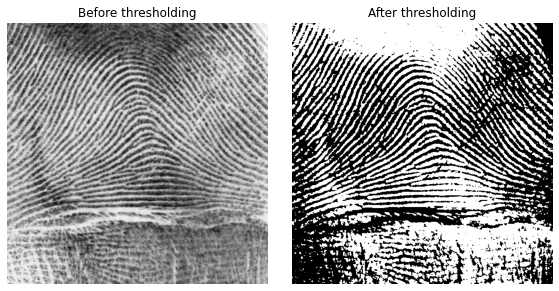

In [35]:
fp = imread('fingerprint.png')

# Global thresholding
T_fp = threshold_otsu(fp)
fp_t = threshold(fp, T_fp)

imagesPlot(fp, fp_t, "Before thresholding", "After thresholding")

# Filtrage spatial par convolution

1. Coder une fonction permettant de réaliser une convolution par un filtre de taille impaire.

In [52]:
def computeLocalConv2D(source, i, j, f):
    
    radius = f.shape[0] // 2
    
    res = np.zeros(f.shape)
    
    # Borders of source channel
    imin = 0
    jmin = 0
    imax = source.shape[0] - 1
    jmax = source.shape[1] - 1
    
    for u in range(-radius, radius+1):
        for v in range(-radius, radius+1):
            if i+u < imin or i+u > imax or j+v < jmin or j+v > jmax:
                res[u + radius, v + radius] = 0 # 0 padding
            else:
                res[u + radius, v + radius] = source[i+u, j+v] * f[u + radius, v + radius]
            
    return sum(res.flatten())

def conv2D1C(channel, f):
    assert len(channel.shape) == 2
    
    new_channel = np.zeros(channel.shape)
    
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            new_channel[i, j] = computeLocalConv2D(channel, i, j, f)
            
    return new_channel
    

def conv2D(image, f):
    
    assert len(f.shape) == 2
    assert f.shape[0] == f.shape[1]
    assert f.shape[0]%2 != 0
    
    if len(image.shape) == 2:
        return conv2D1C(image, f)
    
    assert len(image.shape) == 3
    
    new_image = np.zeros(image.shape)
    
    for c in range(image.shape[2]):
        new_image[:,:,c] = conv2D1C(image[:,:,c], f)
           
    return new_image
        

2. Utiliser cette fonction pour appliquer un filtre moyenneur et un filtre gaussien. Observer les résultats pour différentes images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


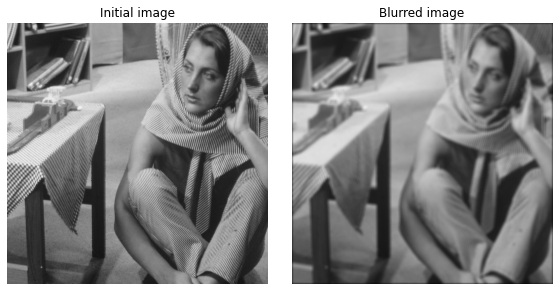

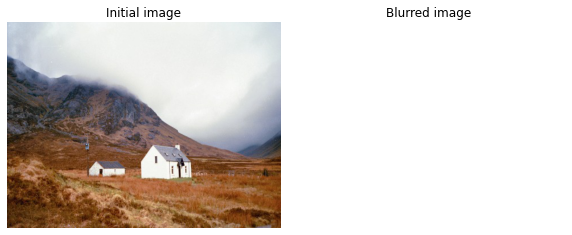

In [60]:
# Mean filter of size (7,7)
fm = np.ones((7,7)) * 1/7**2

barbara = imread('barbara.png')
house = imread('scotland_house.jpg')
blurred_barbara = conv2D(barbara, fm)
blurred_house = conv2D(house, fm)

imagesPlot(barbara, blurred_barbara, "Initial image", "Blurred image")
imagesPlot(house, blurred_house, "Initial image", "Blurred image")

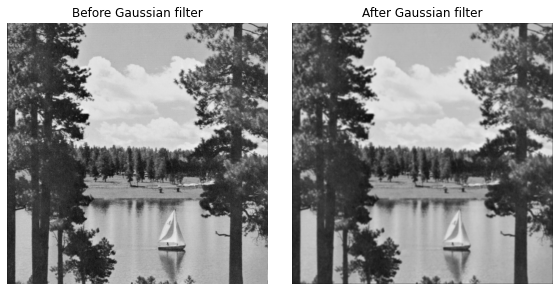

In [72]:
# Gaussian filter of size (3, 3) with 
sigma = 20
g = lambda x,y: np.exp( - (x**2 + y**2) / (2 * sigma**2))
fg = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        fg[i, j] = g(i, j)
        
fg = fg / sum(fg.flatten())

lake = imread('lake.png')
gauss_lake = conv2D(lake, fg)

imagesPlot(lake, gauss_lake, "Before Gaussian filter", "After Gaussian filter")

Le filtre médian est un filtre non linéaire qui consiste à remplacer la valeur de chaque pixel par la valeur médiane de son voisinage.

3. Appliquer un filtre médian sur l'image

# Détection de contours

1. Appliquer les filtres de Prewitt et de Sobel sur des images de test et afficher les images du gradient horizontal et vertical.

2. Calculer l'intensité du gradient et appliquer différents seuillages pour binariser la carte de contours.